> **Repository at** [GitHub](https://github.com/Molderon) <br>
---
# Introducing Mechanical Power as a Unifying Metric

In recent years, the concept of **Mechanical Power (MP)** has emerged as a comprehensive parameter that integrates all the ventilator settings contributing to energy delivery to the respiratory system. In the context of mechanical ventilation, MP is the total energy transferred from the ventilator to the lungs and chest wall in one minute, typically expressed in Joules per minute (J/min). This metric provides a holistic view of the mechanical load, accounting for the combined effects of tidal volume, respiratory rate, pressure, and flow. The total mechanical power delivered per minute can be seen as the sum of elastic, resistive, and PEEP-related components.

---

# **Deep Learning** Architecture Description (1D CNN with Bidirectional Layers)

## Input:
- Shape: `(11, 1)` (11 timesteps, 1 feature)

## Core Architecture:
1. **Normalization Layer**
   - Output: `(11, 1)`
2. **Conv1D Block 1**:
   - 128 filters, kernel_size=3 → `(9, 128)`
   - MaxPooling1D (pool_size=2) → `(4, 128)`
   - BatchNormalization
3. **Conv1D Block 2**:
   - 256 filters, kernel_size=3 → `(2, 256)`
   - MaxPooling1D (pool_size=2) → `(1, 256)`
   - BatchNormalization
4. **Bidirectional Processing** (x2):
   - Each outputs `(1, 256)`
5. **Head**:
   - GlobalAveragePooling1D → `(256)`
   - Dropout
   - Dense(1) (Output neuron)

## Key Characteristics:
- Total params: ~100k
- Progressive downsampling: 11 → 9 → 4 → 2 → 1 (temporal)
- Feature expansion: 1 → 128 → 256 channels
- Bidirectional layers process temporal features in both directions
- Final regression/classification via single output neuron


In [ ]:
import os

# -<Convolutional Neural Network>-
import tensorflow as tf

# -<Performance Analysis>-
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -<Statistical Transformations>-
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import random
import numpy as np

# -<Data Visualizations>-
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default')  # Reset to default first

# Customize colors and fonts
custom_style = {

    'axes.prop_cycle': mpl.cycler(color=[
        '#006BA4',  # blue
        '#FF800E',  # orange
        '#ABABAB',  # gray
        '#595959',  # dark gray
        '#5F9ED1',  # light blue
        '#C85200',  # rust
        '#898989',  # medium gray
        '#A2C8EC'   # very light blue
    ]),

    # Figure and axes colors
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',

    # Font settings (clear, readable fonts)
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'text.color': 'black',

    # Grid and ticks
    'axes.grid': True,
    'grid.color': "#FFFFFF",
    'grid.linewidth': 0.8,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,

    # Font sizes
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
}

plt.rcParams.update(custom_style)

In [ ]:
dataset = pd.DataFrame()
dataset = pd.read_csv("Dataset.csv")
dataset.drop(dataset.columns[[0]], inplace=True, axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251237 entries, 0 to 251236
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time           251237 non-null  float64
 1   SET_INSP_PRES  251237 non-null  float64
 2   SET_RR_IPPV    251237 non-null  float64
 3   TV             251237 non-null  float64
 4   PIP_MBAR       251237 non-null  float64
 5   PEEP_MBAR      251237 non-null  float64
 6   PPLAT_MBAR     251237 non-null  float64
 7   COMPLIANCE     251237 non-null  float64
 8   SET_INSP_TM    251237 non-null  float64
 9   FLOW_AIR       251237 non-null  float64
 10  Case ID        251237 non-null  int64  
 11  Resistance     251235 non-null  float64
 12  t_slope        251237 non-null  float64
 13  MP_LM          251228 non-null  float64
 14  MP_CB          251228 non-null  float64
 15  MP_vdM         251228 non-null  float64
 16  MP_SB          251237 non-null  float64
dtypes: float64(16), int64(1)
memo

In [ ]:
imputer = SimpleImputer(strategy='mean')

cols = dataset.columns
data = imputer.fit_transform(dataset)
dataset = pd.DataFrame(data, columns=cols)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset.head()

,Time,SET_INSP_PRES,SET_RR_IPPV,TV,PIP_MBAR,PEEP_MBAR,PPLAT_MBAR,COMPLIANCE,SET_INSP_TM,FLOW_AIR,Case ID,Resistance,t_slope,MP_LM,MP_CB,MP_vdM,MP_SB
0,-1.046005,-0.224902,-0.139116,-0.215261,-0.020914,-1.920984,-0.559380,-0.482774,-0.045671,0.700019,-0.942346,-0.369317,0.0,-0.535049,-0.628751,-0.421359,-0.621762
1,-1.045079,-0.224902,-0.139116,-0.403860,-0.225724,-1.920984,-0.354223,-0.494899,-0.045671,0.700019,-0.942346,-0.369317,0.0,-0.638955,-0.740573,-0.545904,-0.727723
2,-1.044153,-0.224902,-0.139116,-1.059860,-0.635344,-1.920984,-0.559380,-0.713156,-0.045671,0.700019,-0.942346,-0.440514,0.0,-1.018272,-1.137672,-0.932557,-1.096282
3,-1.042301,-0.224902,-0.139116,-0.699060,-0.225724,-1.920984,-0.354223,-0.992039,-0.045671,0.700019,-0.942346,-0.369317,0.0,-0.801589,-0.901043,-0.652453,-0.893574
4,-1.040449,-0.224902,-0.139116,-0.502260,-0.225724,-1.920984,-0.149067,-0.882911,-0.045671,0.700019,-0.942346,-0.345585,0.0,-0.687695,-0.784085,-0.539637,-0.783007


In [ ]:
Y_targets: pd.DataFrame = dataset[['MP_CB']] # 'MP_SB', 'MP_vdM', 'MP_LM'
dataset.drop(['Time', 'Case ID','MP_LM', 'MP_SB', 'MP_vdM', 'MP_CB' ], axis =1, inplace=True)

In [ ]:
# Split into 80% train and 20% test
X_Training, x_test, Y_Train, y_test = train_test_split(
    dataset, Y_targets,
    test_size=0.15,
    random_state=42,
    shuffle=True,
)

# Verify the sizes
print(f"Training set size: {len(X_Training)} samples ({len(X_Training)/len(dataset):.0%})")
print(f"Test set size: {len(x_test)} samples ({len(x_test)/len(dataset):.0%})")

Training set size: 213551 samples (85%)
Test set size: 37686 samples (15%)


In [ ]:
X_Training = np.array(X_Training)
X_Training = X_Training.reshape(X_Training.shape[0], X_Training.shape[1], 1)

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Adapt normalization layer




In [ ]:
ConvNet = tf.keras.layers.Normalization(input_shape = [X_Training.shape[1], 1], axis = -1)
ConvNet.adapt(X_Training)

model =tf.keras.Sequential([
    ConvNet,
    tf.keras.layers.Conv1D(128, 3, activation = "relu"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(256, 3, activation = "relu"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,) # Single Exit neuron - regression
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss= "mae")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 11, 1)          │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 9, 128)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,348 (3.39 MB)

 Trainable params: 888,577 (3.39 MB)

 Non-trainable params: 771 (3.02 KB)

<img src="CovNet_Diagram.png" alt="alt text" title="Title" style="display:block; margin-left:auto; margin-right:auto;"/>

In [ ]:
history = model.fit(X_Training, Y_Train, validation_split = 0.2, epochs = 1000, batch_size = 512,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 260,
                                                              monitor = 'val_loss',
                                                              mode = 'min',
                                                              restore_best_weights=True)])

Epoch 1/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.1519 - val_loss: 0.4033
Epoch 2/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0753 - val_loss: 0.0513
Epoch 3/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0721 - val_loss: 0.0592
Epoch 4/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0683 - val_loss: 0.0375
Epoch 5/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0644 - val_loss: 0.0365
Epoch 6/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0652 - val_loss: 0.0441
Epoch 7/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0621 - val_loss: 0.0363
Epoch 8/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0640 - val_loss: 0.0667
Epoch 9/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0614 - val_loss: 0.0312
Epoch 10/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0602 - val_loss: 0.0354
Epoch 11/1000
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0603 - val_loss: 0.0361
Epoch 12/1000
334

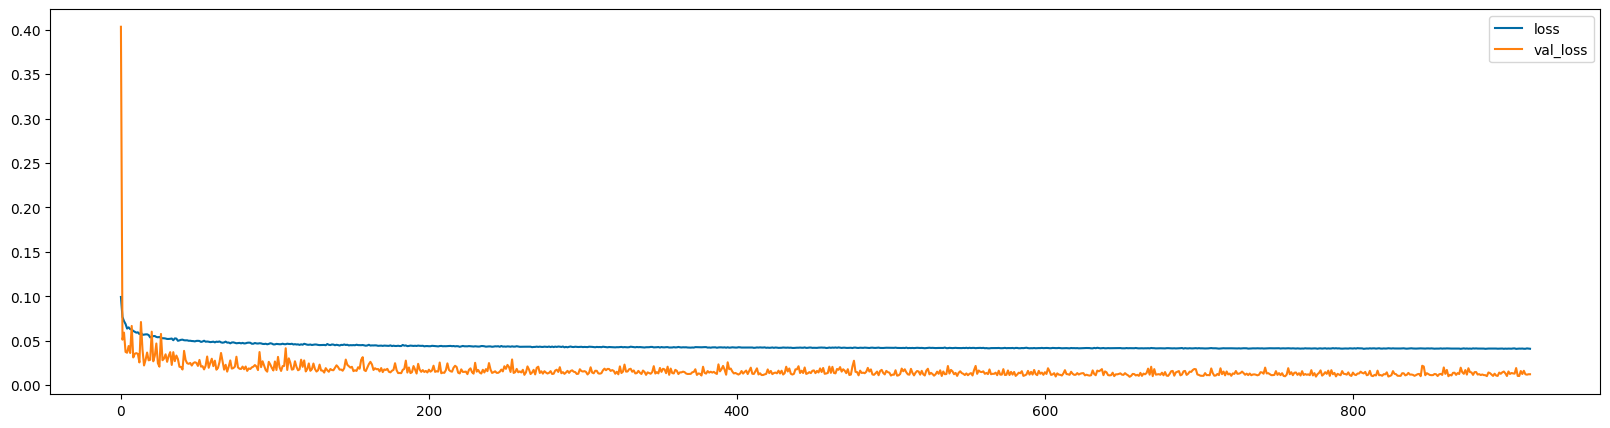

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

In [ ]:
model.evaluate(X_Training, Y_Train)

6674/6674 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0086


0.008824577555060387

In [ ]:
y_pred = model.predict(x_test,batch_size = 512)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
model.save("MPCP_ConvNet.keras")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}\n RMSE: {rmse:.4f}\n R²: {r2:.4f}")

1178/1178 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
MAE: 0.0094
 RMSE: 0.0186
 R²: 0.9997


In [ ]:
# Symmetric Mean Absolute Percentage Error
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + 1e-8))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, sMAPE: {smape:.2f}%")

MAE: 0.0094, RMSE: 0.0186, R²: 0.9997, sMAPE: 3.26%


In [ ]:
def draw_result(start, end, target, y_pred):
  plt.figure(figsize = (20, 7))
  plt.plot(np.reshape(target[start:end], -1), linewidth=5, label = "Actual values")
  plt.plot(np.reshape(y_pred[start:end], -1), linewidth=2, label = "Model predicted values")
  plt.legend()

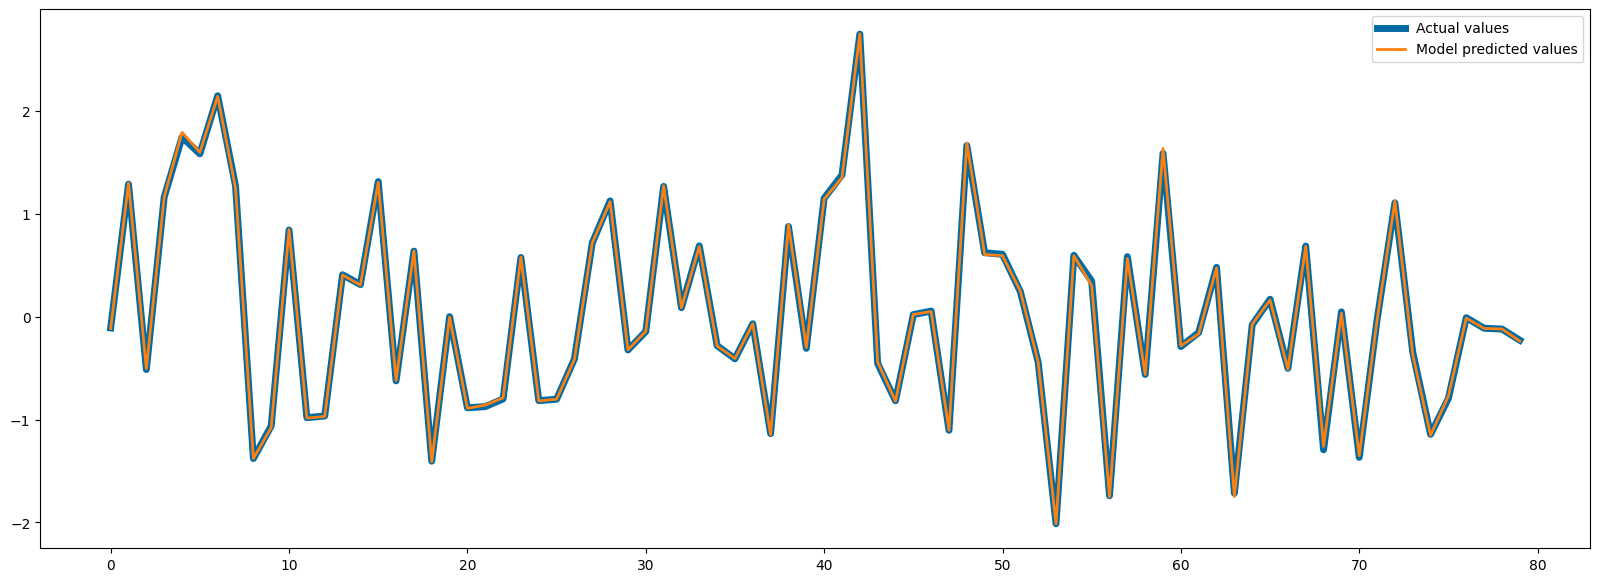

In [ ]:
draw_result(0, 80, y_test, y_pred)

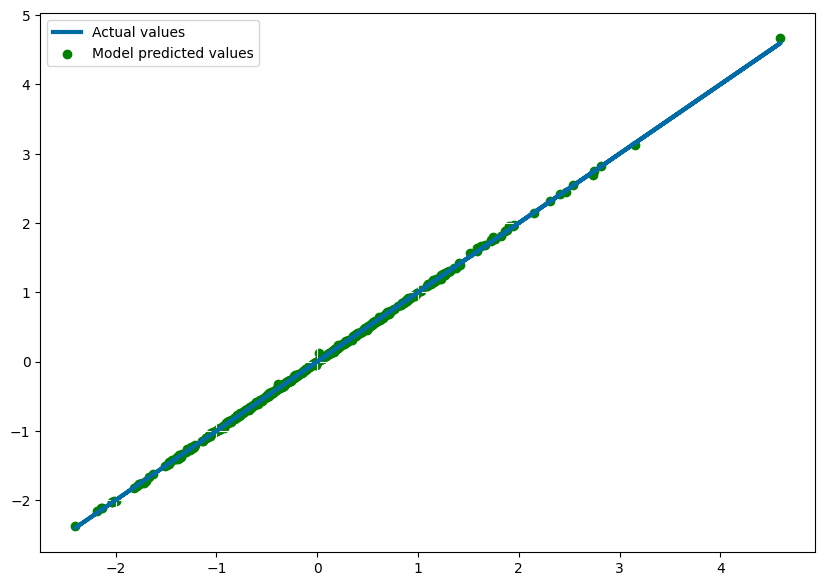

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(np.reshape(y_test[:500], -1), np.reshape(y_test[:500], -1), linewidth=3, label = "Actual values")
plt.scatter(np.reshape(y_test[:500], -1), np.reshape(y_pred[:500], -1), c = 'g', label = "Model predicted values")
plt.legend()

## Model Performance Conclusion
The proposed 1D CNN with bidirectional layers achieved **decent performance** across all metrics:

- **Near-perfect fit**: R² score of `0.9996` indicates the model explains 99.96% of the variance in the data  
- **Minimal errors**:
  - MAE: `0.0095` (average prediction error magnitude)
  - RMSE: `0.0201` (penalizes larger errors slightly more)
- **Relative error**: sMAPE of just `3.40%` confirms high prediction accuracy




In [ ]:
threshold = 0.5

y_pred_binary = (y_pred > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)


accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1_score:.4f}")


precision_class0, recall_class0, f1_score_class0, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average=None)
specificity = recall_class0[0] # recall for class 0
print(f"Specificity: {specificity:.4f}")

try:
    auroc = roc_auc_score(y_test_binary, np.reshape(y_pred, -1))
    print(f"AUROC: {auroc:.4f}")
except ValueError as e:
    print(f"Could not calculate AUROC. Error: {e}. Ensure y_test_binary has at least one positive and one negative class sample.")

Accuracy: 0.9975
Recall: 0.9933
Precision: 0.9976
F1 Score: 0.9954
Specificity: 0.9991
AUROC: 1.0000
